In [61]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt

In [62]:
dataset_path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

path = f"{dataset_path}/data science bowl 2018/stage1_train 2"

Using Colab cache for faster access to the 'data-science-bowl-2018-competition-merged-mask' dataset.


In [64]:
def combine_masks(mask_folder, shape):
    combined = np.zeros(shape, dtype=np.uint8)

    for file in os.listdir(mask_folder):
        m = cv2.imread(os.path.join(mask_folder, file), 0)
        if m is not None:
            combined = np.maximum(combined, m)

    return (combined > 0).astype(np.uint8)

In [65]:
def basic_watershed(dist_map, mask):
    return watershed(-dist_map, mask=mask)

In [67]:
def marker_watershed(dist_map, mask, min_dist=8):
    peaks = peak_local_max(dist_map, min_distance=min_dist, labels=mask)
    markers = np.zeros(dist_map.shape, dtype=int)

    for i, (r, c) in enumerate(peaks):
        markers[r, c] = i + 1

    return watershed(-dist_map, markers, mask=mask)


Sample 1
Ground Truth Objects: 10
Naive Watershed: 13
Marker Watershed: 9


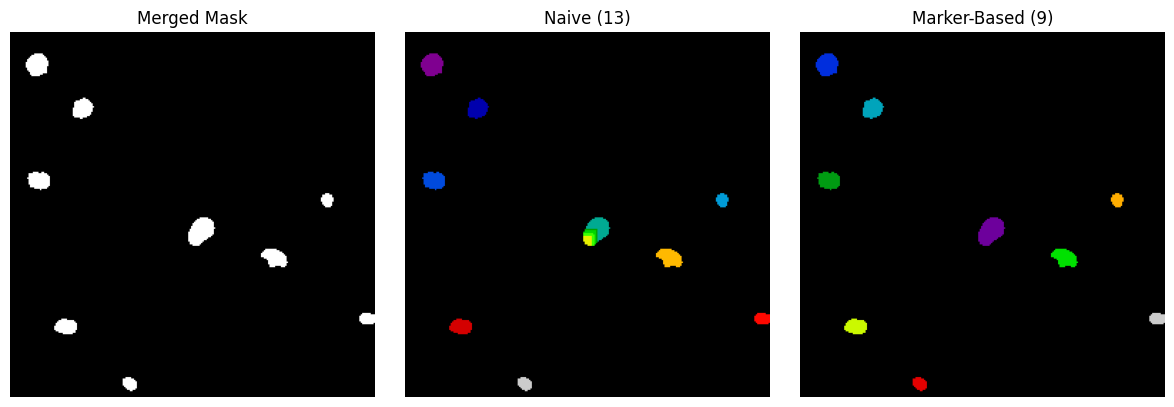


Sample 2
Ground Truth Objects: 24
Naive Watershed: 31
Marker Watershed: 17


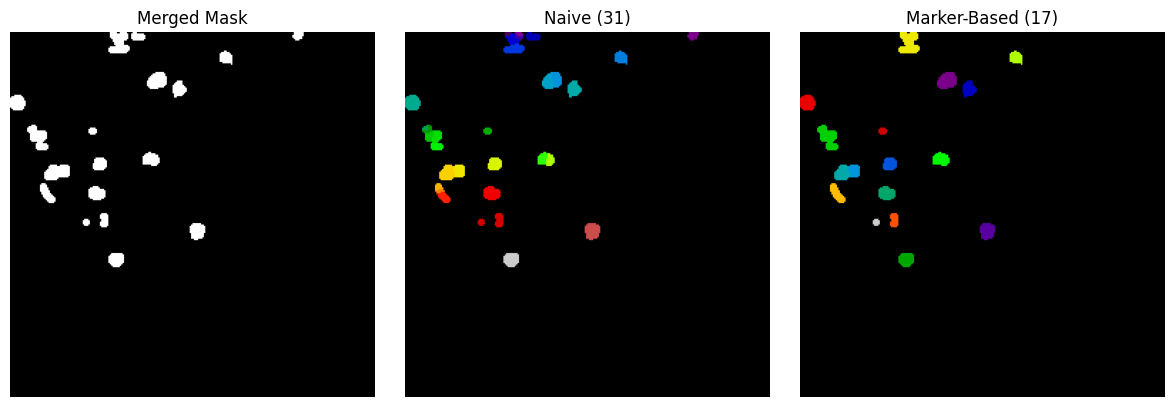


Sample 3
Ground Truth Objects: 10
Naive Watershed: 13
Marker Watershed: 9


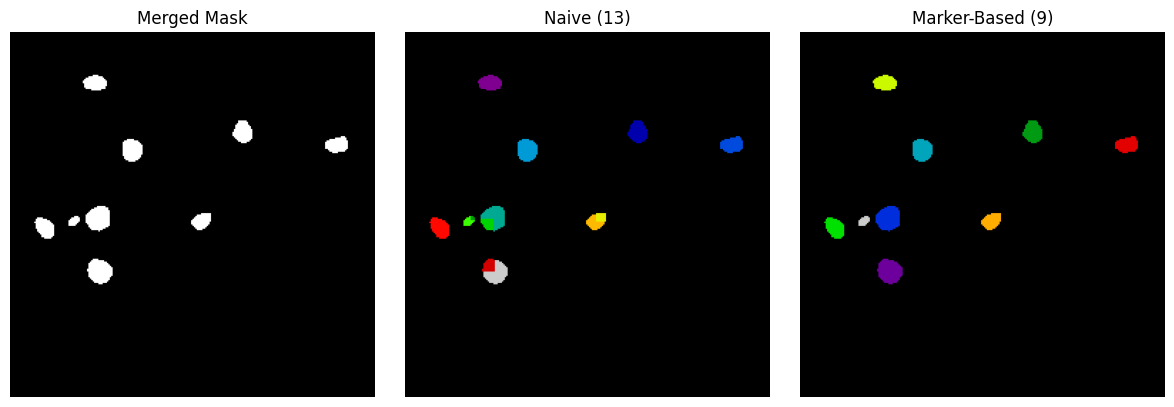


Sample 4
Ground Truth Objects: 5
Naive Watershed: 6
Marker Watershed: 3


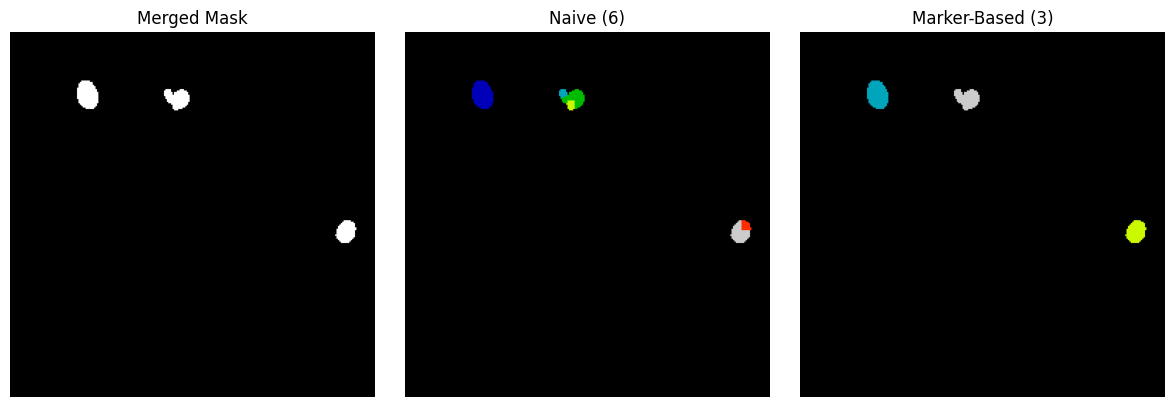


Sample 5
Ground Truth Objects: 13
Naive Watershed: 17
Marker Watershed: 12


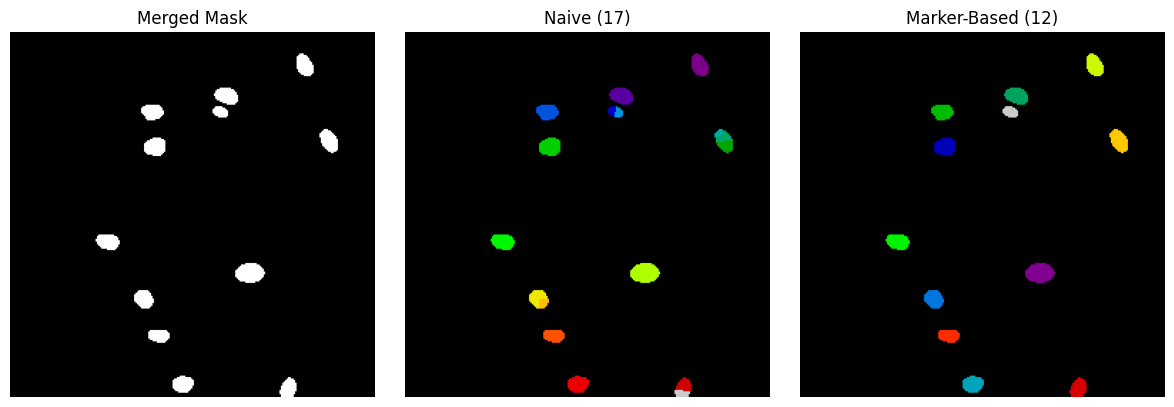


Sample 6
Ground Truth Objects: 21
Naive Watershed: 126
Marker Watershed: 22


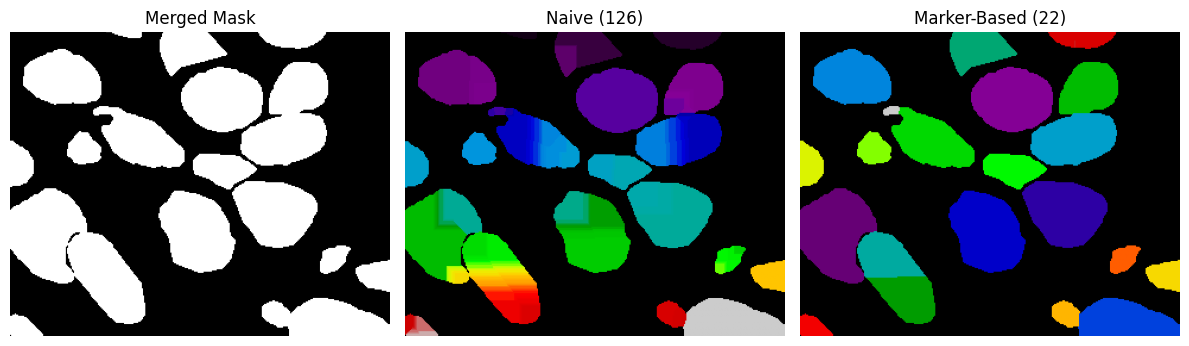

In [69]:
MAX_SAMPLES = 6
count = 0

for folder in os.listdir(path):
    if count >= MAX_SAMPLES:
        break

    sample_path = os.path.join(path, folder)
    img_dir = os.path.join(sample_path, "images")
    mask_dir = os.path.join(sample_path, "masks")

    img_name = os.listdir(img_dir)[0]
    img = cv2.imread(os.path.join(img_dir, img_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    merged_mask = combine_masks(mask_dir, gray.shape)

    gt_objects = len(os.listdir(mask_dir))

    dist = distance_transform_edt(merged_mask)

    naive_result = basic_watershed(dist, merged_mask)

    marker_result = marker_watershed(dist, merged_mask, min_dist=8)

    print(f"\nSample {count+1}")
    print("Ground Truth Objects:", gt_objects)
    print("Naive Watershed:", naive_result.max())
    print("Marker Watershed:", marker_result.max())

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Merged Mask")
    plt.imshow(merged_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title(f"Naive ({naive_result.max()})")
    plt.imshow(naive_result, cmap='nipy_spectral')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f"Marker-Based ({marker_result.max()})")
    plt.imshow(marker_result, cmap='nipy_spectral')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    count += 1